# **Elahe Khodaverdi - 810100132**
### **CA1 - Genetic Algorithm**
In this assignment, we are using a genetic algorithm to solve the curve fitting problem.
We are given a set of data pairs, where each pair represents an x and y value. Additionally, we are provided with intervals for the coefficients, the degree of the polynomial (n), and using this information, we need to make an educated guess or estimate for the polynomial expression that best fits the given data.

First of all, we need to include the necessary libraries.

In [1]:
from typing import NamedTuple
import random
import copy
import matplotlib.pyplot as plt
import numpy as np

To store our input, I have defined a dataclass for it. 
The fields that the input class contains are: 
- ***ex_len*** : It represents the length of the expression or chromosome, which is equal to the degree of the polynomial plus one (one for the constant term).

- ***coefficients***: it's a list of INT number in coefficients interval.

- ***points*** : a dict of data pairs, where each key represents an x and its value represents y value.

In [2]:
class Input(NamedTuple):
    ex_len: int
    coefficients: list[int]
    points: dict[int, int]

In [3]:
def get_input():
    ex_len = int(input()) + 1
    min , max = list(map(input().split(),int))
    coefficients = [ x for x in range(min, max+1)]
    number_of_points = int(input())
    points = {}
    for i in range(number_of_points):
        x , y = list(map(input().split(),int))
        points[x] = y
    return Input(ex_len, coefficients, points)

Also, we have some hyperparameters that we store and use throughout the process. They are stored in the GeneticAlgorithm class, which is defined later, but I will mention them here because I use one of them in an incoming data class. These hyperparameters are:

- ***prob_xover***: The probability of crossover occurring between two chromosomes.  
- ***prob_mutate_chromosome***: The probability of mutation occurring in a chromosome.   
- ***prob_mutate_gene***: The probability of mutation occurring in a gene of a chromosome.
- ***prob_carry***: The percentage of the best chromosomes that will be directly carried over to the next generation.
- ***population_size***: The total number of chromosomes in the population.
- ***max_generations***: The maximum number of generations that the algorithm will explore to find a solution.

Each coefficient is considered as a gene.

Each chromosome consists of an array of genes (with type INT) with a length equal to the degree of the polynomial plus one, along with its fitness value.

In the chromosome data class, we have several method that work as follows:

- **gen_random** : generates a chromosome with random genes. We use this method for the initial population.
- **eval_exp** : evaluates the value of the polynomial expression for a certain x-axis.
- **eval_diff_exps** : evaluate the sum of the differences between our result and the desired value.
- **calc_fitness**: calculates the fitness of each chromosome using the formula:($X_i$ : each $X$ in given points)

$$\frac{1}{1 + \sum_{X_i}|chromosome_{X_i} - goal_{X_i}|}$$



- **mutate**: mutates each gene of the chromosome with a probability of prob_mut_gene.
- **makenonzero**: ensures that the coefficient of the variable with degree n isn't zero.



In [4]:
class Chromosome:
    def __init__(self, genes: list[int], fitness: float):
        self.genes = genes
        self.fitness = fitness
        
    @classmethod
    def gen_random(cls, input: Input):
        genes: list[int] = [None for _ in range(input.ex_len)]
        for i in range(0, input.ex_len):
            gene = random.choice(input.coefficients)
            if(i == input.ex_len -1):
                while(gene == 0):
                    gene = random.choice(input.coefficients)
            genes[i] = gene
        x = cls(genes, 0)
        return x

    def eval_exp(self, x):
        res = 0
        for i in range(0, len(self.genes)):
            res += self.genes[i]*pow(x, i)
        return res

    def eval_diff_exps(self, input: Input):
        sum_diff = 0
        for x in input.points:
            sum_diff += abs(input.points[x] - self.eval_exp(x))
        return sum_diff

    def calc_fitness(self, input: Input):
        diff = self.eval_diff_exps(input)
        self.fitness = float(1 /(1+diff))

    def mutate(self, input: Input,prob_mut_gene: float):
        for i in range(0,len(self.genes)):
            if random.random() < prob_mut_gene:
                gene = random.choice(input.coefficients)
                self.genes[i]= gene
                self.makenonzero(input)

    def makenonzero(self, input):
        while self.genes[len(self.genes)-1] == 0 :
            self.genes[len(self.genes)-1] = random.choice(input.coefficients)

## Genetic Algorithm
I have implemented the genetic algorithm in a class called "GeneticAlgorithm".

The steps of generating a population, selection, mating, crossover, and mutation are all implemented within this class as its methods. Additionally, this class stores the relevant hyperparameters and input data, allowing easy access to them.

- ***generate_population***: generates our initial population.

- ***select_one***: selects one chromosome from the population based on the chromosome's fitness.

- ***mating_pool***: selects good chromosomes as parents for the next generation. The number of selected chromosomes is equal to the population size. Each chromosome is selected using the **select_one** function, and before this process, we need to normalize the fitness of chromosomes.

- ***crossover***: is used to vary the programming of chromosomes with a probability of prob_xover from one generation to the next.

- ***mutate_pool***: mutates each chromosome with a probability of prob_mut_chromosome, and then mutates each gene of that chromosome with a probability of prob_mut_gene.

- ***carried_pool***: carries the best chromosomes to the next generation.

- ***evaluate***: looks for a chromosome with a fitness of one. If such a chromosome exists, it is returned. Otherwise, None is returned.

- ***find_ex***: repeats the process until the answer is obtained or the maximum generation has been reached.

In [5]:
class GeneticَAlgorithm:
    def __init__(self, input: Input, prob_xover, prob_mut_chromosome, prob_mut_gene, prob_carry, population_size, max_generation):
        self.input = input
        self.prob_xover = prob_xover
        self.prob_mut_chromosome = prob_mut_chromosome
        self.prob_mut_gene = prob_mut_gene
        self.prob_carry = prob_carry
        self.population_size = population_size
        self.max_generation = max_generation
        
    def generate_population(self):
        population = [Chromosome.gen_random(self.input) for _ in range(self.population_size)]
        return population

    def select_one(self, population: list[Chromosome]):
        index = 0
        r = random.random()
        while r > 0 and index < len(population):
            r -= population[index].fitness
            index += 1
        index -= 1
        return population[index]

    def mating_pool(self, population: list[Chromosome]):
        pop = copy.deepcopy(population)
        sum_fitness = sum(chromosome.fitness for chromosome in population)
        for chromosome in pop:
            chromosome.fitness =  chromosome.fitness / sum_fitness
        pop = sorted(pop,key=lambda x: -x.fitness)
        new_generation_parents = [copy.deepcopy(self.select_one(pop)) for _ in population]
        return new_generation_parents

    def crossover(self, population: list[Chromosome]):
        new_generation = []
        for i in range(0, len(population), 2):
            if i == len(population) - 1 : 
                break
            children1 = population[i]
            children2 = population[i+1]
            if random.random() <= self.prob_xover:
                point = random.randint(0, self.input.ex_len-1)
                children1.genes[:point], children2.genes[point:] = children2.genes[:point], children1.genes[point:]
            new_generation.append(children1)
            new_generation.append(children2)
        return new_generation

    def mutate_pool(self, population: list[Chromosome]):
        mutated_pool = copy.deepcopy(population)
        for chromosome in mutated_pool:
            if random.random() <= self.prob_mut_chromosome:
                chromosome.mutate(self.input,self.prob_mut_gene)      
        return mutated_pool

    def carried_pool(self, population: list[Chromosome]):
        carry_size = int(self.prob_carry * self.population_size)
        carried_pool = sorted(population, key=lambda chromosome: chromosome.fitness, reverse=True)
        return copy.deepcopy(carried_pool[:carry_size])

    def evaluate(self, population: list[Chromosome]):
        for chromosome in population:
            if int(chromosome.fitness) == 1:
                return chromosome
        return None

    def find_ex(self):
        population = self.generate_population()
        cur_num_generation = 0
        while True:
            if cur_num_generation == self.max_generation:
                return population
            cur_num_generation += 1
            
            for chromosome in population:
                chromosome.calc_fitness(self.input)
            result = self.evaluate(population)
            if result is not None:
                return population

            carried = self.carried_pool(population)
            mating = self.mating_pool(population)
            random.shuffle(population)
            new_generation = self.crossover(mating)
            muted_generation = self.mutate_pool(new_generation)
            population = muted_generation[:self.population_size - len(carried)]
            population.extend(carried)


I have also defined a function to plot the best solution obtained for the polynomial after the process along with the given data points on the chart, so that we can see the accuracy of the solution.

In [6]:
def plotting(curve_fitting: GeneticَAlgorithm, coefficients:list[int]):
    x = list(curve_fitting.input.points.keys())
    y = list(curve_fitting.input.points.values())

    x_curve = np.linspace(min(x), max(x), 100)

    coefficients.reverse()
    y_curve = np.polyval(coefficients, x_curve)
    plt.plot(x, y, 'ro', label='Points')
    plt.plot(x_curve, y_curve, label='Polynomial Curve')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Plot of Points and Polynomial Curve')

    plt.legend()

    plt.show()

## Two Example

In [1]:


input_data = Input(
    ex_len=3,
    coefficients=[x for x in range(-15, 15)],
    points={0:1 ,-1: 0, 1: 5}
)
input_data2 = Input(
    ex_len=4,
    coefficients=[x for x in range(-6, 10)],
    points={0: 1, 1: 0, 2: -5, -1:-8}
)

curve_fitting = GeneticَAlgorithm(
    input=input_data,
    prob_xover=0.55,
    prob_mut_chromosome=0.45,
    prob_mut_gene=0.55,
    prob_carry=0.1,
    population_size=100,
    max_generation=2000
)

last_generation = curve_fitting.find_ex()
best = sorted(last_generation, key=lambda x: -x.fitness)[0]
coefficients = best.genes
print(coefficients, best.fitness)
plotting(curve_fitting, coefficients)


NameError: name 'Input' is not defined

## Generate Random Example

[4, -20, -7, -3, -20, -12, 10, -4, 4, 3] 1.0


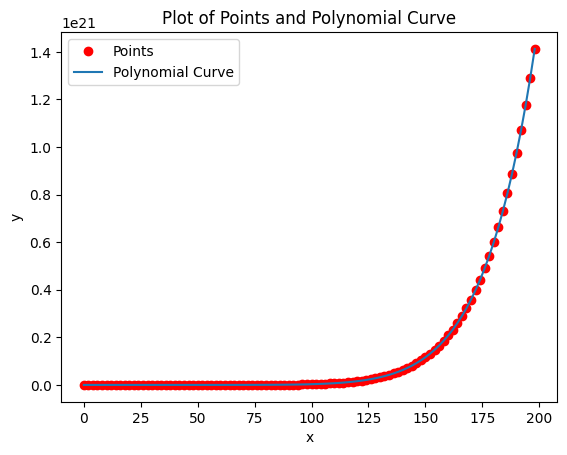

In [385]:

input_data3 = Input(
    ex_len= 10,
    coefficients = [x for x in range(-20,20)],
    points={}
)
ex_chromosome = Chromosome.gen_random(input_data3)
for  i in range(0,200,2):
    input_data3.points[i] = ex_chromosome.eval_exp(i)


curve_fitting = GeneticَAlgorithm(
    input=input_data3,
    prob_xover=0.55,
    prob_mut_chromosome=0.45,
    prob_mut_gene=0.55,
    prob_carry=0.1,
    population_size=100,
    max_generation=2000
)

last_generation = curve_fitting.find_ex()

best = sorted(last_generation, key=lambda x: -x.fitness)[0]
coefficients = best.genes
print(coefficients, best.fitness)
plotting(curve_fitting, coefficients)


In [387]:
print(ex_chromosome.genes)


[4, -20, -7, -3, -20, -12, 10, -4, 4, 3]


## Questions
1. - Large population size: Using a large population size increases computational cost due to the requirement of more computational resources and time. It also increases the likelihood of convergence of the population in the first steps and generations, so the algorithm won't explore the search space enough. Additionally, it makes it hard to identify the actual optimal solution.

    - Small population size: becuase of less diversity and slower exploration of the search space the algorithm requires more generation to converge and being closer to the optimal answer. With a small population size, there are fewer potential solutions being evaluated each generation. Random variations or mutations between generations could cause promising solutions to be lost if they are not represented elsewhere in the population. A small population will converge more quickly, losing diversity earlier in the search. Without enough diverse solutions, the algorithm is more likely to converge to a local optimum (a high-scoring but suboptimal solution) rather than finding the global or true best solution.

2. Increasing the population size in each step may increase the accuracy because it increases diversity and the algorithm has less probability to get stuck in local maxima. However, with a larger population size, each step will require more memory and time consumption and we may have some limits in memory and time. We should get the result in a reasonable time within a certain memory space. Additionally, with more diversity it may become harder for the algorithm to converge and find the optimal result.
3. Crossover combines two chromosomes to create new chromosomes for the next generation and create variation. Mutation changes a chromosome to get rid of local maxima. If we only use crossover, we will have a much higher probability of getting stuck in local maxima and not finding the optimal result. And if we only use mutation, our algorithm works like a brute force approach and it will be very hard to get the optimal result. So it is not possible to use only one of them because they have different effects.
4. Initialize the population with candidate curves seeded by performing a fast linear regression fit on the data, rather than randomly generating curves. This provides the genetic algorithm with a head start by starting with curves that have already been fit to the data.
5. Some possible reasons are:
The probabilities of crossover and mutation may be too small that it's not enough to cause significant changes to the chromosomes along the way.
It's possible that the initial population has been selected in a way where the individuals are too similar, or that when they are gathered together they naturally follow similar paths and over time become even more similar without enough variation being introduced.
To solve this problem, we can increase the probabilities of crossover and mutation to introduce more variation into the chromosomes. We can also repeat the algorithm multiple times with new random initial populations to avoid getting stuck in this problem. 
6. we can set a limit for the number of generation will evaluate by algorithm. like how we did in our algorithm and have a hyperparameter called *max_generation*.
7. As the degree of the polynomial increases, the time taken to find the coefficients of the polynomial increases. This is because as the number of genes increases, the number of states related to the equation increases (considering the range of coefficients of the problem). The algorithm requires more time to guess and find the equation through operations such as crossover and mutation.
8. As the number of data points given increases, we may be able to more accurately guess the polynomial, but more time is required. This is because, for example, checking each point for every chromosome takes a lot of time. On the other hand, if the number of data points given is less, our accuracy decreases and it is even possible that the number of points may not be sufficient to guess the polynomial. However, we may be able to reach an answer with a fitness of 1 faster, which may or may not be our desired answer.